In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing
from scipy.optimize import least_squares

In [2]:
def solve_vdp(K, MU, N):
    '''
    Solve the coupled VDP eqn for a given set of params, K and MU.
    
    MU == 0. ... 0. -> reduces to simple harmonic motion.
    
    N - number of coupled masses.
    '''
    t0, tf = 0., 8. # initial and final integration times
    nframes = 2 ** 8 # number of time steps

    d = 6. # distance between rest positions (uniform)
    
    # set rest positions of springs + boards
    R = np.arange(0, d *(N + 1 + 1), d, dtype=np.float_)

    # set initial positions of springs
    X = np.copy(R)
    X[1] -= 1.8 
    X[-2] -= 2.4

    # Set up the linear system.
    XV = np.zeros(2 * N)
    XV[:N] = X[1:-1] # Initial positions of the springs
    XV[N:] = np.zeros(N) # initial velocities of the springs
    
    # Acceleration function
    F_accel = lambda DX, XV: -K * (DX[1:-1] - DX[:-2]) + \
        K * (DX[2:] - DX[1:-1]) + MU * (1 - np.power(DX[1:-1], 2)) * XV[N:]
    
    # Wrapper on F_accel, which operates on DX, to operate on XV = DX, V instead
    def F(t, XV):
        DX = np.hstack( ([0.], XV[:N], [X[-1]]) ) - R 
        res = np.hstack(( XV[N:], F_accel(DX, XV) ) 
                        )
        return res
    
    # Use SciPy timestepping to solve the problem.
    soln = solve_ivp(F, [t0, tf], XV,
                    t_eval=np.linspace(t0,tf,nframes))
    return soln


In [3]:
def solve_vdp_demo(N=5):
    # Default values for the VDP solver
    K = (np.arange(N) - N / 3) ** 2. #np.ones(N)
    K[1] += 1 #lolol
    K[2] += 1
    MU = 0.5 * np.ones(N)
    print(f'K == {K}')
    print(f'MU == {MU}')
    return solve_vdp(K, MU, N), N

def plot_trails(solny, N, dots=False, save=False, savename=''):
    for i in range(N):
        if dots:
            plt.plot(solny[i, :], soln.t, 'bo')
        else:
            plt.plot(solny[i, :], soln.t)
        
        if save:
            plt.savefig(savename, dpi=256)
    return

data_ptr = []

K == [2.77777778 1.44444444 1.11111111 1.77777778 5.44444444]
MU == [0.5 0.5 0.5 0.5 0.5]
7.252779394488011


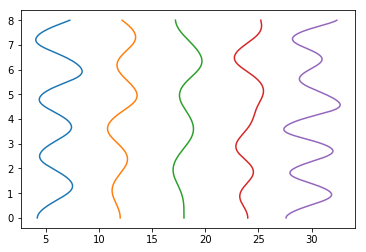

In [4]:
soln, N = solve_vdp_demo()
plot_trails(soln.y, N, save=True, savename='assets/vdp_anneal_exact.png')

print(soln.y[0,-1])

K == [2.77777778 1.44444444 1.11111111 1.77777778 5.44444444]
MU == [0.5 0.5 0.5 0.5 0.5]


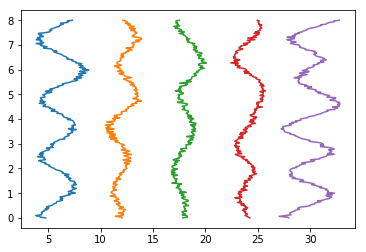

In [5]:
def add_noise(data, noise_param=0.2):
    noise = np.random.standard_normal(data.y.shape)
    noisy_data = data.y + noise_param * noise
    return noisy_data

# Testing a way to generate noisy data once and keeping it in the cell.
def generate_data(data_ptr):
    if data_ptr:
        return
    else:
        data, N = solve_vdp_demo()
        noised_data = add_noise(data)
        data_ptr.append( data.t )
        data_ptr.append( noised_data )
        
generate_data(data_ptr)

plot_trails(data_ptr[1], N, save=True, savename='vdp_anneal_perturbed')

In [66]:
# Run simulated annealing?

In [85]:

def curve_diffs(params, N, Tdata, Ydata, *args):
    '''
    Solve the VDP for the current params and compare it to the data.
    Return the cost of the VDP soln with the given params.
    '''
    K = params #MU = params[:N], params[N:]
    MU = np.ones(N) * 0.5 # let's make it easier for you..
    
    soln = solve_vdp(K, MU, N) # Don't actually need to use Tdata
    
    error = np.sqrt( np.sum( (soln.y - Ydata) ** 2 ) )
    return error

In [86]:
%%time
from scipy.optimize import dual_annealing
# inputs to SA
Ydata = data_ptr[1]
tdata = data_ptr[0]
N = 5

Kmins = np.zeros(N)
Kmaxes = np.ones(N)* 50
#MUmins = np.zeros(N)
#MUmaxes = np.ones(N) * 10

#param_mins = np.hstack( (Kmins, MUmins) )
#param_maxes = np.hstack(( Kmaxes, MUmaxes ))
param_mins = Kmins
param_maxes = Kmaxes

guess = dual_annealing(curve_diffs, list(zip(param_mins, param_maxes)), args=(N, tdata, Ydata), maxiter=1000)
print(guess)

     fun: 10.98574762407213
 message: ['Maximum number of iteration reached']
    nfev: 16493
    nhev: 0
     nit: 1000
    njev: 0
       x: array([2.84569198, 1.35595609, 1.13386859, 1.79755329, 5.38041261])
CPU times: user 5min 29s, sys: 35.4 ms, total: 5min 29s
Wall time: 5min 30s


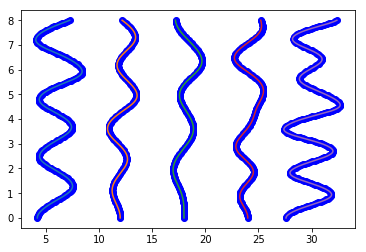

In [74]:
Kguess = guess.x

N = 5
guess_soln = solve_vdp(Kguess, np.ones(N) * 0.5, N)

plot_trails(guess_soln.y, N, dots=True)
plot_trails(soln.y, N)


In [89]:
%%time
from scipy.optimize import least_squares

IC = np.ones(N) # initial guess for spring constants
#IC = Kguess
# nonlinear least squares
res_lsq = least_squares(curve_diffs, IC, args=(N, tdata, Ydata))

k_found = res_lsq.x

print(k_found)
print(f'N function evals: {res_lsq.nfev}')

[0.39578786 1.04846218 0.44780101 0.94577385 0.60404188]
N function evals: 71
CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 1.94 s


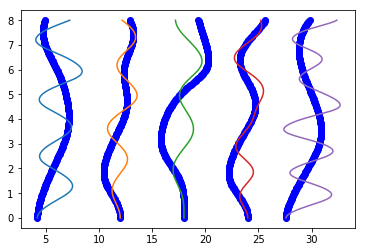

In [90]:
lsq_guess_soln = solve_vdp(k_found, np.ones(N) * 0.5, N)

plot_trails(lsq_guess_soln.y, N, dots=True)
plot_trails(soln.y, N)

# way faster, but only finds a local optimum?

In [ ]:
# Naive annealing?



In [81]:
def anneal(cost, s0, T0=1., beta=1-1e-3, Tthresh=1e-4, nsteps=2**12, args=[]):
    '''
    Naive annealing with an exponential-decay temperature function.
    
    cost: cost function
    s0, T0: initial state and temperature. Type(s0) == Type(Input(cost))
    beta: Decay parameter for temperature
    Tthresh: minimal value of T before reset
    nsteps: number of steps before termination
    '''
    step_size = 0.5 # Controls generation of neighbour states

    xbest = s0
    cbest = cost(s0, *args)

    curr_x = s0
    curr_cost = cost(s0)

    T = T0
    for _ in range(nsteps):
        xnbr = step_size * np.random.standard_normal(curr_x.shape) + curr_x
        cost_nbr = cost(xnbr)

        if cost_nbr < cbest: # new best state
            xbest = xnbr
            cbest = cost_nbr
        else:
            delta = max( (cost_nbr - curr_cost ) / curr_cost, 0 )

            # Choose nbr with probability governed by T
            R = np.random.rand()
            if R < np.exp( - delta / T ):
                curr_x = xnbr
                curr_cost = cost_nbr

        # lower the temperature
        T = beta * T 
        if T < Tthresh:
            T = T0
            
    return xbest, cbest

In [83]:

N = 5
IC = np.ones(N)
solution = anneal(curve_diffs, IC)

TypeError: curve_diffs() missing 3 required positional arguments: 'N', 'Tdata', and 'Ydata'